<a href="https://colab.research.google.com/github/guidomoor/FEA-ML/blob/main/CNN_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Convert MNIST Image Files into a 4-Dimensions thensor
# (# of images, Height, Width, Color Channel)

transform = transforms.ToTensor()

In [4]:
# We need to setup out data

#Train Data
train_data = datasets.MNIST(root='/cnn_data', train = True, download = True, transform = transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.19MB/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 57.9kB/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:06<00:00, 245kB/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.85MB/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [5]:
# Test Data

test_data = datasets.MNIST(root='/cnn_data', train = False, download = True, transform = transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
# Create a small batch size for images, 10
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [9]:
# Model Class (definition of our model)
#self. , object oriented format

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1) #1st convolutional NN
    self.conv2 = nn.Conv2d(6,16,3,1) #2nd convolutional NN
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120) #1st fully connected NN (5*5*16 is the lastpooling output, 120 arbitrary)
    self.fc2 = nn.Linear(120, 84) #2nd
    self.fc3 = nn.Linear(84, 10) #3rd (it has to finish with 10, that's the batch size)

  # push information through the NNs
  def forward(self, x):
    #1st Pass (conv + pooling)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2) #2x2 kernel, stride 2
    #2nd Pass (conv + pooling)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)

    #Re-View to flatten it out
    x = x.view(-1, 5*5*16) #negative one so that we can vary the batch size

    #Fully Connected Layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) #we don't do relu on th elast one

    return F.log_softmax(x, dim = 1)



In [10]:
# Create Instance of our Model

torch.manual_seed(41)
model = ConvolutionalNetwork() #Convolutional Network as we did before
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
# Loss function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #the smaller the lr, the longer it takes to train


In [12]:
# this is to understand how long it takes (time)
import time
start_time = time.time()

#Create Variables to Track Things
epochs = 5 #train and test 5 times
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of Epochs
for i in range(epochs):
  trn_corr = 0 #training correct
  tst_corr = 0 #testing correct

  #Train
  for b, (X_train, y_train) in enumerate(train_loader): #train loader, size 10
    b+=1 #start bathes at 1
    y_pred = model(X_train) #get predicted values from training set. This is not flattened, it's 2D
    loss = criterion(y_pred, y_train) #calculate loss

    predicted = torch.max(y_pred.data, 1)[1] #add up number of correct predictions. Index off the 1st point
    batch_corr = (predicted == y_train).sum() #how many we got correct from the batch
    trn_corr += batch_corr #keep track as we go along in training

    #Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Print out some results
    if b%600 == 0:
      print(f'epoch: {i}  batch: {b}  loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  #Kickoff Test
  with torch.no_grad(): #turn off gradient tracking, don't update out weights with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f' Training Took : {total}')



epoch: 0  batch: 600  loss: 0.16236241161823273
epoch: 0  batch: 1200  loss: 0.16415399312973022
epoch: 0  batch: 1800  loss: 0.50989830493927
epoch: 0  batch: 2400  loss: 0.13064125180244446
epoch: 0  batch: 3000  loss: 0.005703830160200596
epoch: 0  batch: 3600  loss: 0.4654758870601654
epoch: 0  batch: 4200  loss: 0.0047060707584023476
epoch: 0  batch: 4800  loss: 0.002044482622295618
epoch: 0  batch: 5400  loss: 0.05938424542546272
epoch: 0  batch: 6000  loss: 0.0005587349878624082
epoch: 1  batch: 600  loss: 0.0032875302713364363
epoch: 1  batch: 1200  loss: 0.251935213804245
epoch: 1  batch: 1800  loss: 0.002331273164600134
epoch: 1  batch: 2400  loss: 0.003220777492970228
epoch: 1  batch: 3000  loss: 0.02436981536448002
epoch: 1  batch: 3600  loss: 0.2470351755619049
epoch: 1  batch: 4200  loss: 0.031400538980960846
epoch: 1  batch: 4800  loss: 0.00040996214374899864
epoch: 1  batch: 5400  loss: 0.00030610361136496067
epoch: 1  batch: 6000  loss: 0.30289459228515625
epoch: 2  ba

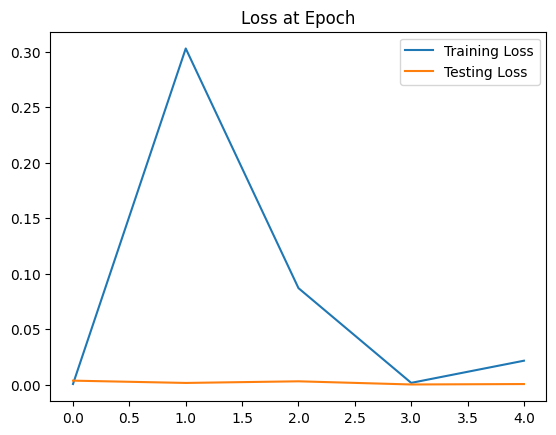

In [16]:
# Graph the loss
#need to convert the tensor back to numpy
train_losses = [t1.item() for t1 in train_losses]
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Testing Loss')
plt.title('Loss at Epoch')
plt.legend()

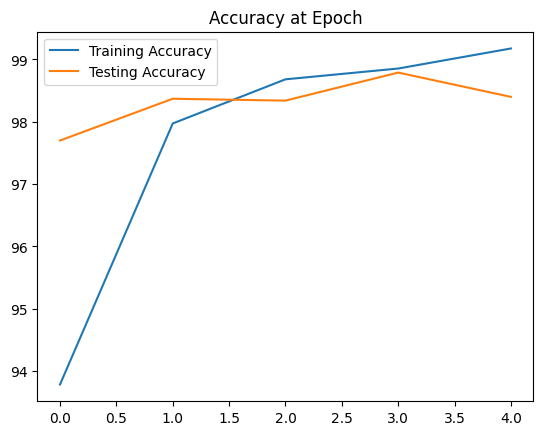

In [17]:
# graph accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at Epoch')
plt.legend()

In [19]:
#check final
test_load_final = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [20]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_final:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [21]:
# Correct items?
correct.item() #out of 10000

9840

In [23]:
# Run new image thorugh CNN
test_data[4142] #this is giving me a tensor with an image in it
#at the end there is a number in it.

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [24]:
test_data[4142][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [25]:
test_data[4142][0].reshape(28,28) #this is the image reshape size

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

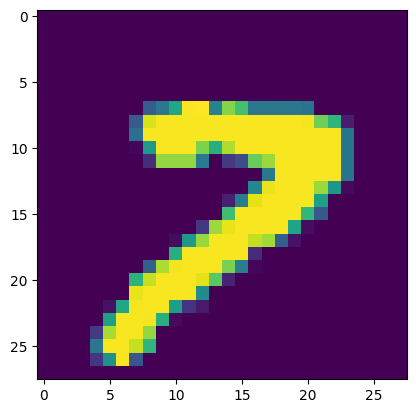

In [26]:
#show image
plt.imshow(test_data[4142][0].reshape(28,28))

In [30]:
# pass the image through the model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4142][0].reshape(1,1,28,28)) #batch size of 1, 1 color channel, 28x28 image
print(new_prediction.argmax())



tensor(7)
